<h1 style="font-family: Trebuchet MS; padding: 12px; font-size: 30px; color: #081c15; text-align: center; line-height: 1.25;"><span style="color: #52b788; font-size: 48px"><b>🎥Sentiment Analysis Model Deployment
📹</b></span><br></h1>
<hr>

<a id=0 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Overview</p>

#### **Hi👋**


This project involves building a sentiment analysis application using the IMDb movie review dataset. The objective is to classify movie reviews as positive or negative based on their content and deploy the solution to showcase practical skills in AI, ML, and MLOps.

Steps Overview:
1. **Dataset Preparation:**  Use the IMDb dataset (50,000 labeled reviews) for training and testing. Preprocess reviews by cleaning text, tokenizing, and converting into numerical features.
2. **Model Training:** Train a sentiment analysis model (Logistic Regression, LSTM,CNN, or BERT) to predict sentiment. Evaluate using accuracy, precision, recall, and F1-score.
3. **Flask API:** Develop a REST API to serve predictions. The API accepts a review and returns the sentiment (positive/negative).
4. **Dockerization:** Containerize the application using Docker to ensure portability and scalability.
5. **GitHub Actions for CI/CD:** Automate deployment with a pipeline that:
    * Builds and pushes the Docker image to DockerHub.
    * Deploys the application to a cloud platform.
6. **Deployment:** Host the API on a cloud service (e.g., AWS, GCP) and expose it via a public URL.


#### **Let's jump right away to the code!**

<a id=1 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Exploratory Data Analysis</p>

First thing first, there's always an EDA to give us a sense of what data we are dealing with. It's also useful to acquire some insights, informations, and even mistakes from data

### Load and Explore the Data

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [2]:
# Paths to dataset
train_dir = "./aclImdb/train"
test_dir = "./aclImdb/test"

def load_data(directory):
    data = {"review": [], "sentiment": []}
    for label in ["pos", "neg"]:
        sentiment = 1 if label == "pos" else 0
        path = os.path.join(directory, label)
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
                data["review"].append(file.read())
                data["sentiment"].append(sentiment)
    return pd.DataFrame(data)

# Load train and test data
train_data = load_data(train_dir)
test_data = load_data(test_dir)

# Combine for preprocessing
data = pd.concat([train_data, test_data], ignore_index=True)


In [3]:
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (50000, 2)


,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [4]:
data.tail()

,review,sentiment
49995,I occasionally let my kids watch this garbage ...,0
49996,When all we have anymore is pretty much realit...,0
49997,The basic genre is a thriller intercut with an...,0
49998,Four things intrigued me as to this film - fir...,0
49999,David Bryce's comments nearby are exceptionall...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [6]:
# Check class distribution
print("Class distribution:")
print(data['sentiment'].value_counts())


Class distribution:
1    25000
0    25000
Name: sentiment, dtype: int64


<h1 style="font-family: Trebuchet MS; font-size: 25px; color:rgb(83, 182, 151); text-align: left; "><b>● Visualization </b></h1>

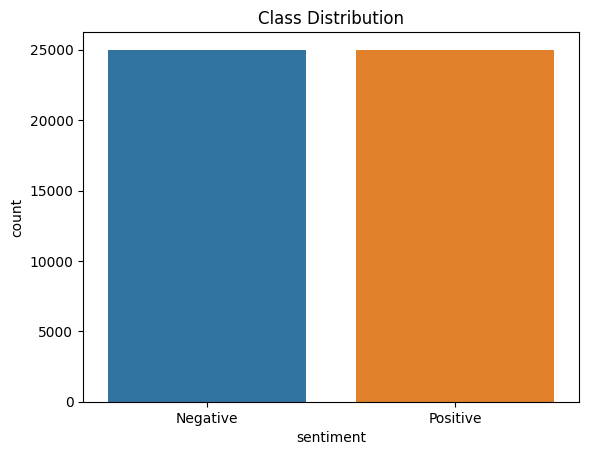

In [7]:
# Plot class distribution
sns.countplot(data=data, x='sentiment')
plt.xticks([0, 1], labels=['Negative', 'Positive'])
plt.title("Class Distribution")
plt.show()


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* There is no difference between those 2 types of movies reviews (positive or negative)

<h1 style="font-family: Trebuchet MS; font-size: 25px; color:rgb(74, 170, 91); text-align: left; "><b>● Visualization 2</b></h1>

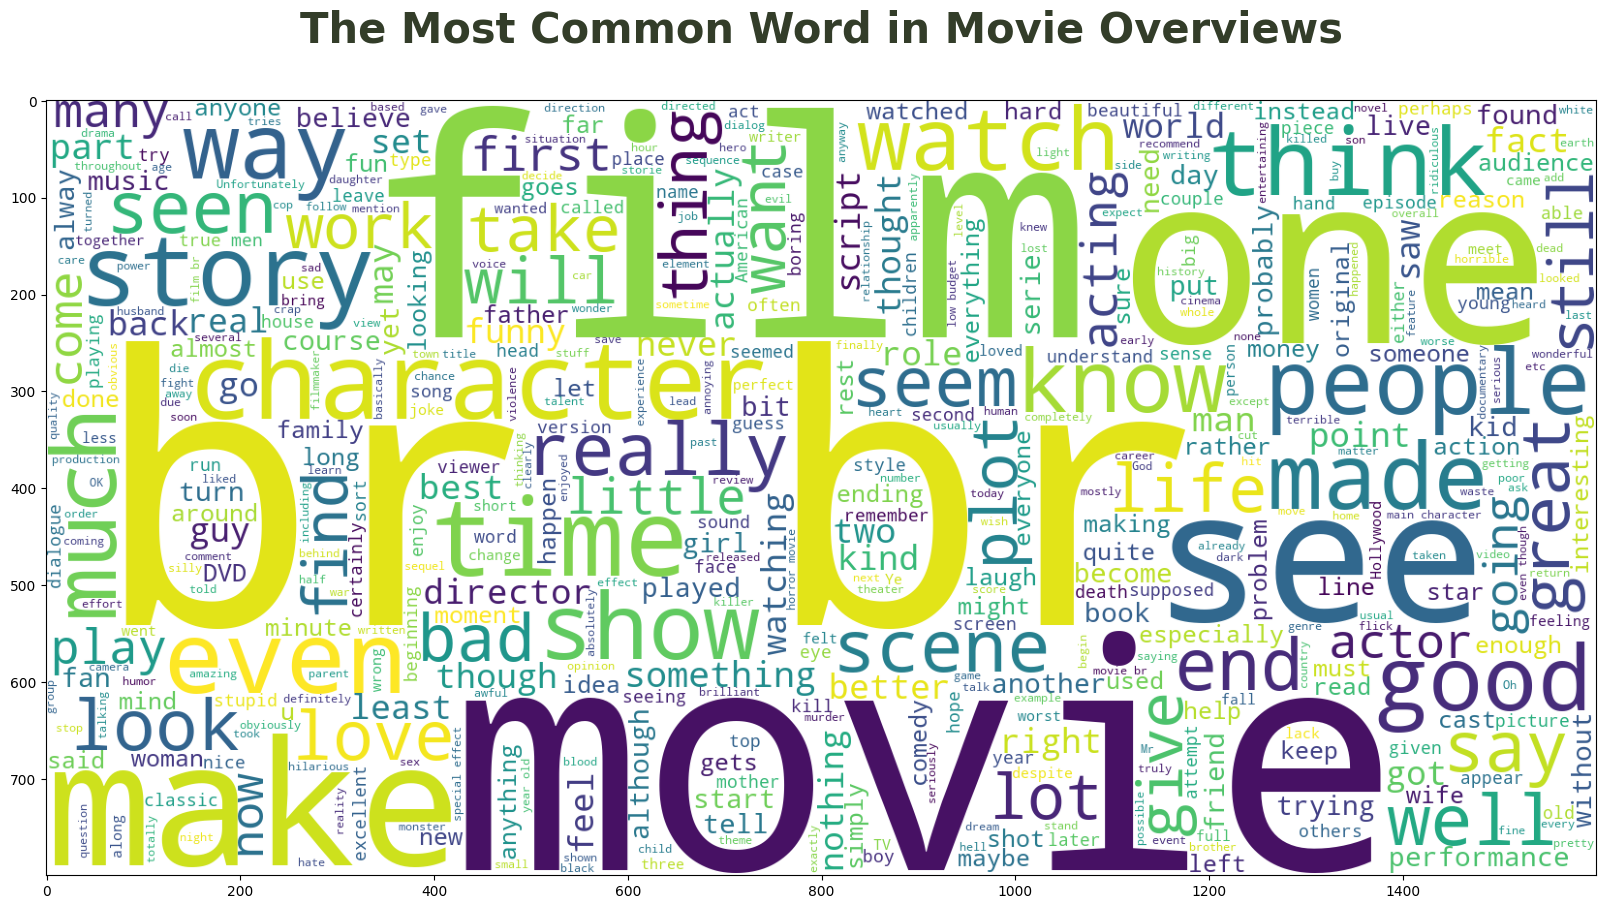

In [8]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,height=800,width=1600,background_color="white").generate(' '.join(data['review']))

plt.imshow(wc)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Word "movie", "film", "see", "br" apparently appear in many occasions

<a id=2 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px"> Text Preprocessing</p>

Clean the text for analysis and modeling:

In [9]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords 
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# Preprocessing function
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
data["cleaned_review"] = data["review"].apply(preprocess_text)
data.drop(columns=["review"], inplace=True)
data.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atefi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,sentiment,cleaned_review
0,1,bromwell high cartoon comedy ran time programs...
1,1,homelessness houselessness george carlin state...
2,1,brilliant overacting lesley ann warren best dr...
3,1,easily underrated film inn brooks cannon sure ...
4,1,typical mel brooks film much less slapstick mo...


<a id=3 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px"> Save Preprocessed Data</p>

Save the cleaned dataset to a CSV file:

In [10]:
data.to_csv("preprocessed_imdb.csv", index=False)
print("Preprocessed data saved to 'preprocessed_imdb.csv'")


Preprocessed data saved to 'preprocessed_imdb.csv'


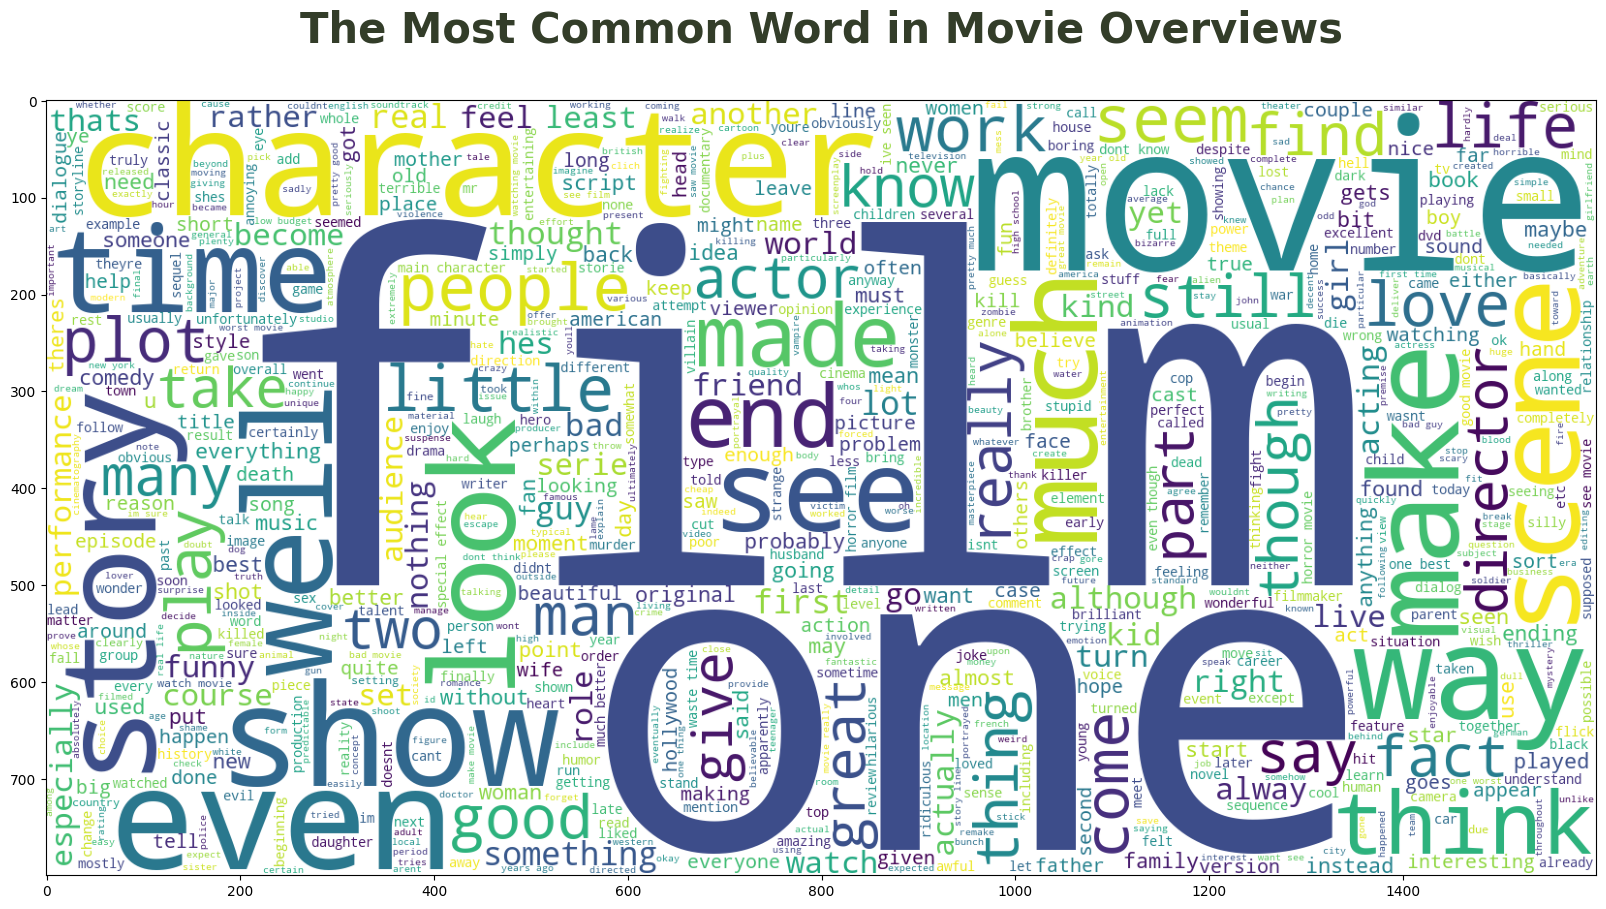

In [11]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,height=800,width=1600,background_color="white").generate(' '.join(data['cleaned_review']))

plt.imshow(wc)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Word "movie", "film", "one", "character" apparently appear in many occasions

# Load the preprocessed data

In [12]:
import pandas as pd

data = pd.read_csv("preprocessed_imdb.csv")

print(data.head())


   sentiment                                     cleaned_review
0          1  bromwell high cartoon comedy ran time programs...
1          1  homelessness houselessness george carlin state...
2          1  brilliant overacting lesley ann warren best dr...
3          1  easily underrated film inn brooks cannon sure ...
4          1  typical mel brooks film much less slapstick mo...


##  Split Dataset
Split the dataset into training and validation sets:

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data["cleaned_review"], data["sentiment"], test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_val)}")


Training set size: 40000
Testing set size: 10000


<a id=4 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px"> TF-IDF Feature Extraction</p>

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features for simplicity

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation data
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f"TF-IDF feature matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF feature matrix shape (validation): {X_val_tfidf.shape}")


TF-IDF feature matrix shape (train): (40000, 5000)
TF-IDF feature matrix shape (validation): (10000, 5000)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle


with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

<a id=5 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px"> Train a Baseline Model</p>

##  "Logistic Regression"

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = log_reg.predict(X_val_tfidf)

# Evaluate the model
print("Classification Report:\n")
print(classification_report(y_val, y_pred))

# Overall accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4945
           1       0.89      0.90      0.89      5055

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 0.89


## Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB

# Initialize Naive Bayes classifier
nb = MultinomialNB()

# Train the model
nb.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_nb = nb.predict(X_val_tfidf)

# Evaluate the model
print("Naive Bayes - Classification Report:\n")
print(classification_report(y_val, y_pred_nb))

# Overall accuracy
accuracy_nb = accuracy_score(y_val, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")


Naive Bayes - Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4945
           1       0.86      0.86      0.86      5055

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Naive Bayes Accuracy: 0.86


#### Save the Best Model

In [18]:
import joblib

with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(log_reg, model_file)
print("Model saved successfully!")


Model saved successfully!


# Example: Predict the sentiment of a new sample

In [19]:
# Load the model
with open('logistic_regression_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

print("Model loaded successfully!")


Model loaded successfully!


In [20]:
new_sample = ["This movie was very good!"]
new_sample_tfidf = tfidf_vectorizer.transform(new_sample)  # Transform input using the same vectorizer
prediction = model.predict(new_sample_tfidf)

# Display prediction
print("Prediction:", "Positive" if prediction[0] == 1 else "Negative")

Prediction: Positive


In [21]:
new_sample = ["This movie was bad!"]
new_sample_tfidf = tfidf_vectorizer.transform(new_sample)  # Transform input using the same vectorizer
prediction = model.predict(new_sample_tfidf)

# Display prediction
print("Prediction:", "Positive" if prediction[0] == 1 else "Negative")

Prediction: Negative


<a id=6 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px"> Deep Learning Models</p>

#  Data Preparation for DL


In [22]:
#  Data Preparation for DL
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")  # Limit to top 5000 words
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=200, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=200, padding='post', truncating='post')

print(f"Padded training data shape: {X_train_padded.shape}")
print(f"Padded validation data shape: {X_val_padded.shape}")


Padded training data shape: (40000, 200)
Padded validation data shape: (10000, 200)


###  CNN model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model using Sequential API
model = Sequential([

    # Embedding layer: turns integers (word indices) into dense word vectors of fixed size
    # input_dim=5000: the size of the vocabulary (the top 5000 words)
    # output_dim=128: the size of the embedding vectors for each word
    # input_length=200: length of each input sequence (after padding/truncating)
    Embedding(input_dim=5000, output_dim=128, input_length=200),

    # Convolutional Layer: applies convolutional filters to extract local features from the text
    # filters=128: number of convolutional filters (features to extract)
    # kernel_size=5: size of the filter (in this case, 5 words)
    # activation='relu': Rectified Linear Unit activation function to introduce non-linearity
    Conv1D(filters=128, kernel_size=5, activation='relu'),

    # MaxPooling Layer: down-samples the output of the convolutional layer to reduce dimensionality
    # pool_size=4: takes the maximum value over every 4 words in the feature map
    MaxPooling1D(pool_size=4),

    # Another Convolutional Layer: to further extract features
    Conv1D(filters=128, kernel_size=5, activation='relu'),

    # Another MaxPooling Layer: applies the same operation as the previous pooling layer
    MaxPooling1D(pool_size=4),

    # Flatten Layer: flattens the output from the convolutional layers into a 1D vector
    # This is necessary before feeding the data into the fully connected layers (Dense)
    Flatten(),

    # Dropout Layer: randomly sets a fraction of input units to zero during training to prevent overfitting
    # 0.5 means 50% of the neurons will be dropped
    Dropout(0.5),

    # Fully Connected (Dense) Layer: used to make the final prediction
    # output_dim=1: for binary classification, we have 1 output (e.g., 0 or 1)
    # activation='sigmoid': sigmoid function is used for binary classification (outputs a value between 0 and 1)
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

model.build(input_shape=(None, 200))
model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=0.001),  
    metrics=['accuracy']  
)

model.summary()


c:\Users\atefi\anaconda3\envs\yolo\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 196, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 45, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,505 (3.07 MB)

 Trainable params: 805,505 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_val_padded, y_val),
    epochs=5, 
    batch_size=32    
)


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7354 - loss: 0.4756 - val_accuracy: 0.8837 - val_loss: 0.2871
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9016 - loss: 0.2412 - val_accuracy: 0.8791 - val_loss: 0.2926
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9426 - loss: 0.1518 - val_accuracy: 0.8707 - val_loss: 0.3612
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9701 - loss: 0.0828 - val_accuracy: 0.8600 - val_loss: 0.4696
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9844 - loss: 0.0462 - val_accuracy: 0.8442 - val_loss: 0.7018


### Evaluate the Model

In [29]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val_padded, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy:.2f}")

y_pred = (model.predict(X_val_padded) > 0.5).astype("int32")

from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_val, y_pred))


Validation Accuracy: 0.84
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85      4945
           1       0.90      0.78      0.83      5055

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



##  Save the Trained Model

In [30]:
model.save('sentiment_model.h5') 

In [35]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

model = load_model('sentiment_model.h5')


tokenizer = Tokenizer(num_words=5000) 

new_sample = ["This movie was good!"]

new_sample_seq = tokenizer.texts_to_sequences(new_sample)

new_sample_padded = pad_sequences(new_sample_seq, maxlen=200)  

# Predict the sentiment
prediction = model.predict(new_sample_padded)
print ("The Prediction Value is = ",  prediction[0])
# Display prediction
print("Prediction:", "Positive" if prediction[0] > 0.5 else "Negative")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
The Prediction Value is =  [0.57659286]
Prediction: Positive


The Next step is Develop a **REST API** to serve predictions. The API accepts a review and returns the sentiment (positive/negative).
<h1 style="font-family: Trebuchet MS; font-size: 60px; color:rgb(55, 146, 108); text-align: center;"><b>Let's Go</b></h1>